# E-commerce Customer Analysis

This notebook explores and analyzes customer data from an e-commerce platform. The goal is to understand customer behavior and predict yearly spending using various regression models.

## Contents
- Data Loading
- Data Preprocessing
- Exploratory Data Analysis (EDA)
- Model Training & Evaluation
- Model Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


## 1. Data Loading
Load the e-commerce customer dataset and display the first few rows to understand its structure.

In [2]:
def load_data():
    try:
        df = pd.read_csv("ecommerce.csv")
        return df
    except Exception as e:
        raise Exception(f"Error loading data: {e}")

df = load_data()
df.head()


,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


## 2. Data Preprocessing
Prepare the data for modeling by handling missing values, encoding categorical variables, scaling features, and splitting into training and test sets.

In [3]:
def preprocess_data(df, test_size=0.2):
    df_processed = df.copy()
    df_processed = df_processed.drop(['Email', 'Address', 'Avatar'], axis=1)
    
    X = df_processed.drop('Yearly Amount Spent', axis=1)
    y = df_processed['Yearly Amount Spent']
    
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()
    
    for col in numerical_features:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
    
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    try:
        feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    except AttributeError:
        feature_names = numerical_features + categorical_features
    
    X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)
    
    return X_train_df, X_test_df, y_train, y_test, preprocessor, numerical_features, categorical_features

X_train, X_test, y_train, y_test, preprocessor, num_feats, cat_feats = preprocess_data(df)


## 3. Exploratory Data Analysis (EDA)
Visualize the distribution of the target variable and explore relationships between features using plots and correlation matrices.

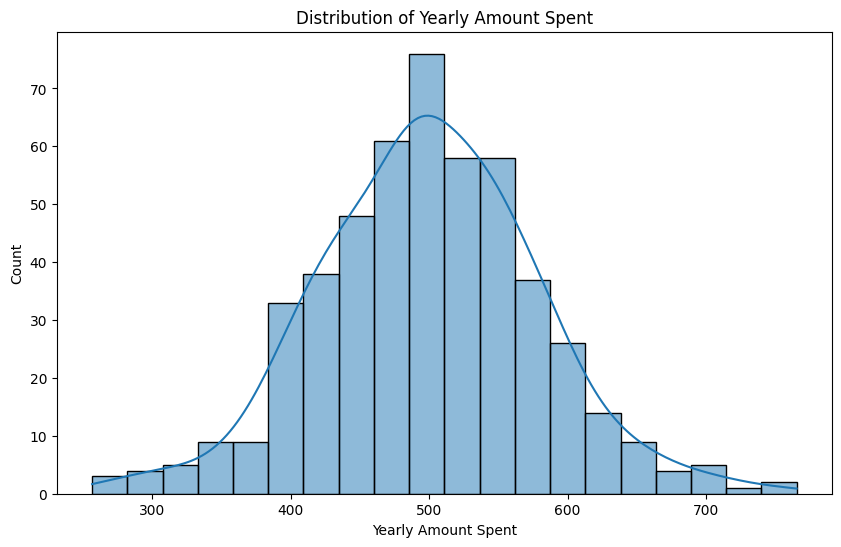

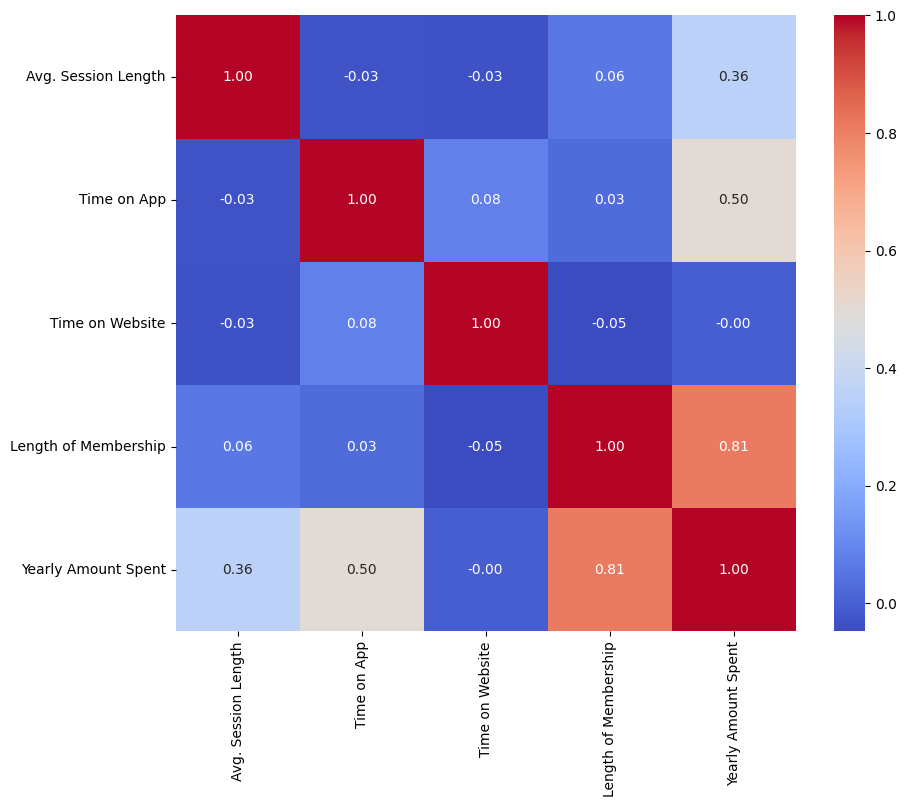

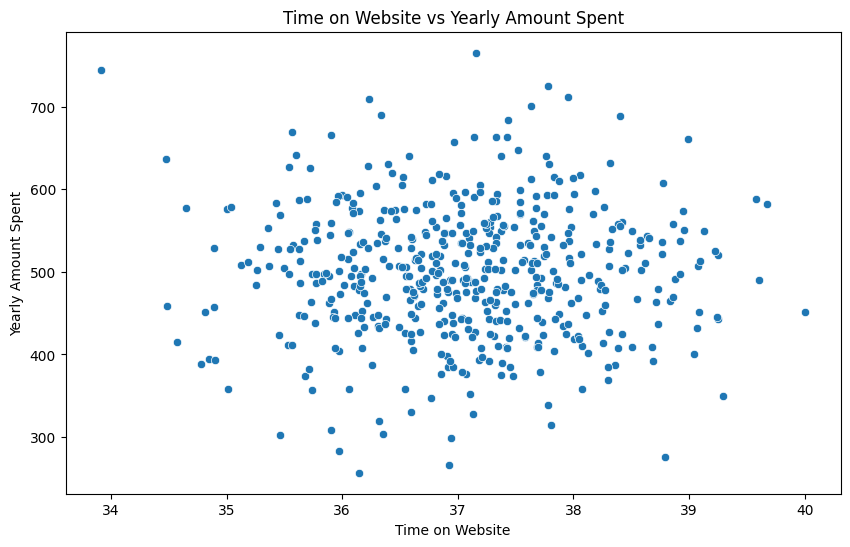

In [4]:
def plot_eda(df, feature=None):
    plots = []
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.histplot(df["Yearly Amount Spent"], kde=True, ax=ax1)
    ax1.set_title("Distribution of Yearly Amount Spent")
    plots.append(fig1)
    
    numeric_df = df.select_dtypes(include=["float64", "int64"])
    corr_matrix = numeric_df.corr()
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax2)
    plots.append(fig2)
    
    if feature in numeric_df.columns and feature != "Yearly Amount Spent":
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        sns.scatterplot(x=df[feature], y=df["Yearly Amount Spent"], ax=ax3)
        ax3.set_title(f"{feature} vs Yearly Amount Spent")
        correlation = df[feature].corr(df["Yearly Amount Spent"])
        plots.append((fig3, correlation))
    else:
        plots.append(None)
    
    return plots

plots = plot_eda(df, feature="Time on Website")
for p in plots:
    if p is not None:
        if isinstance(p, tuple):
            plt.show(p[0])
        else:
            plt.show(p)


## 4. Model Training & Evaluation
Train multiple regression models and evaluate their performance using metrics such as MSE, RMSE, and R².

In [5]:
def train_models(X_train, y_train, X_test, y_test, models_to_train):
    results = {}
    for model_name in models_to_train:
        if model_name == "Linear Regression":
            model = LinearRegression()
        elif model_name == "Ridge":
            model = Ridge()
        elif model_name == "Lasso":
            model = Lasso()
        elif model_name == "Random Forest":
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_name == "Gradient Boosting":
            model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        elif model_name == "SVR":
            model = SVR()
        else:
            continue
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[model_name] = {"model": model, "mse": mse, "rmse": np.sqrt(mse), "r2": r2}
    
    results_df = pd.DataFrame({
        "Model": list(results.keys()),
        "MSE": [results[m]["mse"] for m in results],
        "RMSE": [results[m]["rmse"] for m in results],
        "R²": [results[m]["r2"] for m in results]
    })
    
    return results_df

models_to_train = ["Linear Regression", "Random Forest"]
results_df = train_models(X_train, y_train, X_test, y_test, models_to_train)
results_df


,Model,MSE,RMSE,R²
0,Linear Regression,109.863741,10.481591,0.977813
1,Random Forest,328.696044,18.129976,0.933620


## 5. Model Selection
Identify the best-performing model based on the evaluation metrics and summarize the results.

In [6]:
best_idx = results_df["R²"].idxmax()
best_model_name = results_df.loc[best_idx, "Model"]
print(f"Best Model: {best_model_name}")


Best Model: Linear Regression
